# Лабораторная работа 1
### Выполнил: Покумин Георгий Алексеевич

### EDA (исследовательский анализ данных)

In [9]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Узнаем количество столбцов, их типы, количество объектов. Проверяем данные на наличие пропусков. Понимаем, что они есть, но их не так много.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40453 entries, 0 to 40452
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       40453 non-null  int64  
 1   carat    40453 non-null  float64
 2   cut      40453 non-null  object 
 3   color    40453 non-null  object 
 4   clarity  40389 non-null  object 
 5   depth    40396 non-null  float64
 6   table    40453 non-null  float64
 7   x        40405 non-null  float64
 8   y        40393 non-null  float64
 9   z        40411 non-null  float64
 10  theta1   40453 non-null  int64  
 11  theta2   40453 non-null  int64  
 12  price    40453 non-null  int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 4.0+ MB


Интерпретируем признаки. С помощью интернета была найдена информация о большинстве признаков. 

Carat - вес камня в каратах, делаем первое предположение, что этот признак больше всех будет влиять на таргет - price(цена). 

Color - цвет бриллианта, существует специальная система цветов, где каждый цвет закодирован буквами. Чем выше цвет в системе, тем бриллиант дороже. В наших данных встречаются только полностью бесцветные (D, E, F) или почти бесцветные (G, H, I, J) - самые дорогие цвета. Изначально считали, что цвет бриллианта должен сильно влиять на цену, однако, учитывая малое разнообразие цветов данных и то, что наши цвета самые дорогие, можем сделать вывод о том, что цвет не должен сильно влиять на цену. 

Clarity - чистота камня. В системе классификации существует 5 групп (в порядке убывания цены): F - flawless, IF - internally flawless, VS, VS - very slightly included, SI - slightly included, I - included. В наших данных есть представители каждой группы, возможно, признак будет иметь сильное влияние на итоговую цену.

Cut - огранка алмаза. В наших данных под cut подразумевается качество огранки: Ideal, Premium, Very Good, Good, Fair. Возможно, признак будет иметь сильное влияние на итоговую цену.

X, Y, Z - размеры камня. Должны иметь сильную корреляцию с каратами (весом) и также сильно влиять на стоимость бриллианта.
Table - плоская поверхность на самой вершине камня. Идеальное значение отличается для разных камней. Предоположение - влияние есть, но не такое сильное как у остальных признаков.

Depth - высота алмаза, измеряемая от нижнего кончика до table. Зависит от размеров алмаза (возможна корреляция), отличается для разных камней. Предоположение - влияние есть, но не такое сильное как у остальных признаков.

Theta1, Theta2 - разберемся с ними потом.

Id - скорее всего, просто номер бриллианта.

In [11]:
data.color.unique()

array(['F', 'I', 'E', 'H', 'D', 'G', 'J'], dtype=object)

In [12]:
data.clarity.unique()

array(['VVS2', 'VS1', 'IF', 'VS2', 'VVS1', 'SI1', 'SI2', nan, 'I1'],
      dtype=object)

In [13]:
data.cut.unique()

array(['Ideal', "'Very Good'", 'Premium', 'Good', 'Fair'], dtype=object)

Смотрим основные статистики наших данных. Видим, что в столбцах x, y, z есть нулевые значения, являющиеся выбросами (нулевая длина, высота или ширина алмаза не возможны). Также замечаем, что в столбце y есть слишком большие значения - примерно 9430.

In [14]:
data.describe()

,id,carat,depth,table,x,y,z,theta1,theta2,price
count,40453.000000,40453.00000,40396.000000,40453.000000,40405.000000,40393.000000,40411.000000,40453.000000,40453.000000,40453.000000
mean,26946.030529,0.77475,61.755897,57.438563,5.704927,18.773722,3.523399,19.071738,19.036190,3736.247003
std,15761.901131,0.41728,1.425065,2.225439,1.033411,350.627591,0.656404,8.527417,8.570144,3615.804536
min,3.000000,0.28000,43.000000,43.000000,0.000000,0.000000,0.000000,5.000000,5.000000,334.000000
25%,13160.000000,0.40000,61.100000,56.000000,4.740000,4.750000,2.930000,11.000000,11.000000,979.000000
50%,27038.000000,0.70000,61.800000,57.000000,5.700000,5.710000,3.520000,19.000000,19.000000,2401.000000
75%,40768.000000,1.03000,62.500000,59.000000,6.510000,6.510000,4.020000,27.000000,27.000000,5154.000000
max,53939.000000,2.02000,79.000000,79.000000,8.800000,9428.922353,31.800000,33.000000,33.000000,18803.000000


Посмотрим на другие выбросы с помощью boxplot. Достаточно много выбросов находится в depth и table. Четко видны вышеупомянутые выбросы в x, y, z, а также видны новые выбросы в z. Theta1, theta2 не имеют выбросов и, возможно, распределены равномерно, похоже на искусственную величину.

<Figure size 1000x600 with 0 Axes>

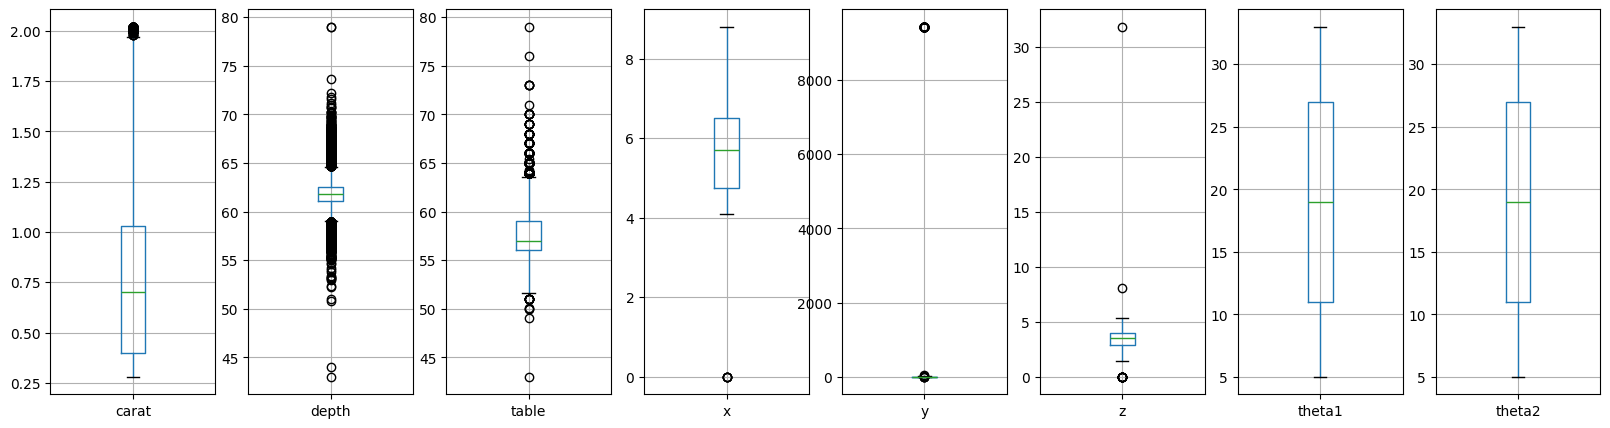

In [15]:
plt.figure(figsize=(10, 6))
selected_columns = ['carat', 'depth', 'table', 'x', 'y', 'z', 'theta1', 'theta2']
fig, axes = plt.subplots(1, len(selected_columns), figsize=(20, 5))
for i, col in enumerate(selected_columns):
    data[[col]].boxplot(ax=axes[i])  
plt.show()

Построим корреляционную матрицу, для этого закодируем натуральными числами категориальные признаки в соответствии с системой классификации стоимости бриллиантов.

<Axes: >

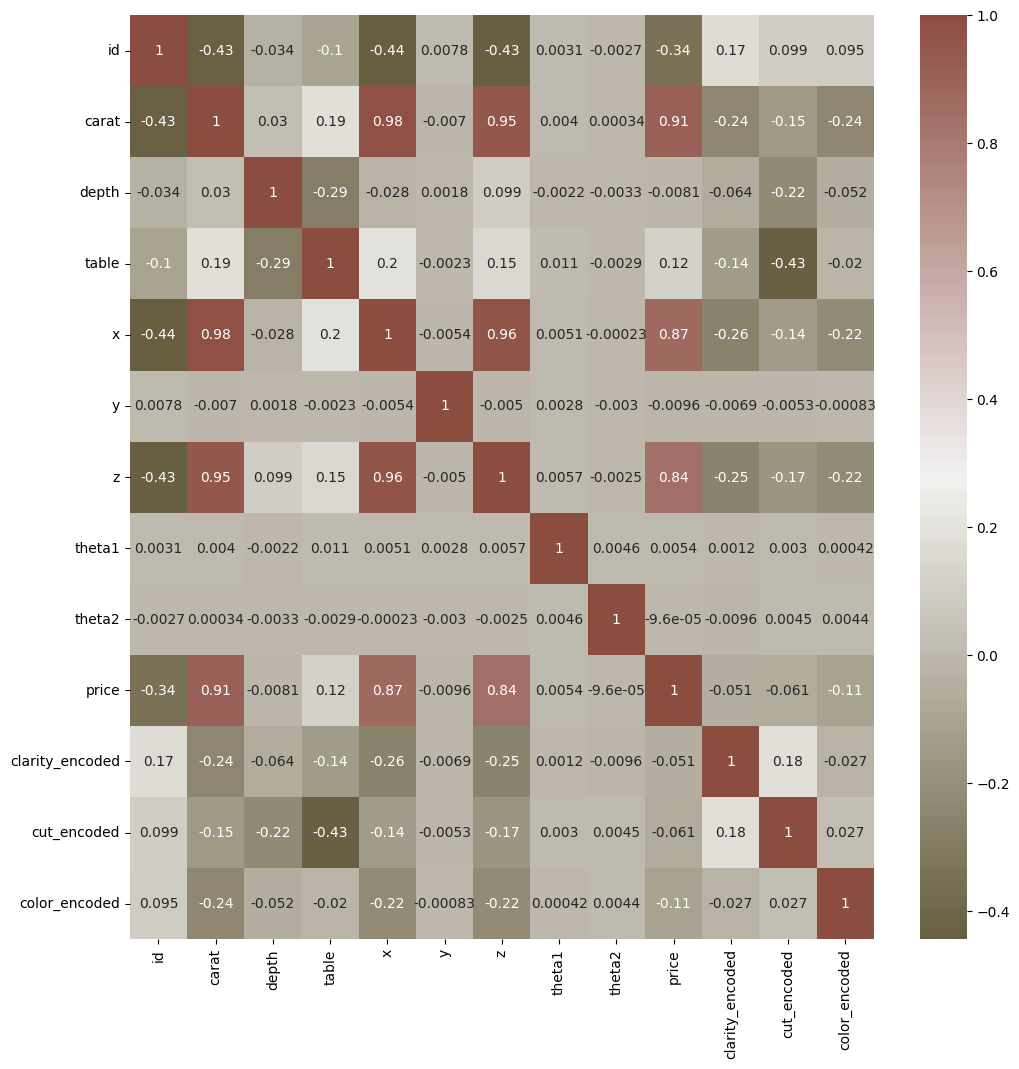

In [16]:
clarity_mapping = {'IF': 9, 'VVS2': 8, 'VVS1': 6, 'VS2': 5, 'VS1': 4, 'SI2': 3, 'SI1': 2, 'I1': 1}

cut_mapping = {'Ideal': 5, 'Premium': 4, '\'Very Good\'': 3, 'Good': 2, 'Fair': 1}

color_mapping = {'F': 5, 'I': 2, 'E': 6, 'H': 3, 'D': 7, 'G': 4, 'J': 1}

data_encoded = data.copy()

data_encoded['clarity_encoded'] = data_encoded['clarity'].map(clarity_mapping)
data_encoded['cut_encoded'] = data_encoded['cut'].map(cut_mapping)
data_encoded['color_encoded'] = data_encoded['color'].map(color_mapping)
data_encoded = data_encoded.drop(columns=['cut', 'clarity', 'color'])

cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= data_encoded.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

Как и предполагалось очень сильная зависимость таргета от каратов, х и z (скорее всего y нет в этом списке из-за выбросов). Однако как мы видим, другие признаки практически не значимы. Видим предположенную корреляцию между каратами и размерами бриллианта и несколько других корреляций. Попробуем сделать то же самое, только предварительно удалив выбросы. Неожиданным оказалось увидеть корреляцию id и price. Также видим корреляцию id с price, x, z. Возможно, id это не просто индекс, а имеющий какое-то значение признак.

<Axes: >

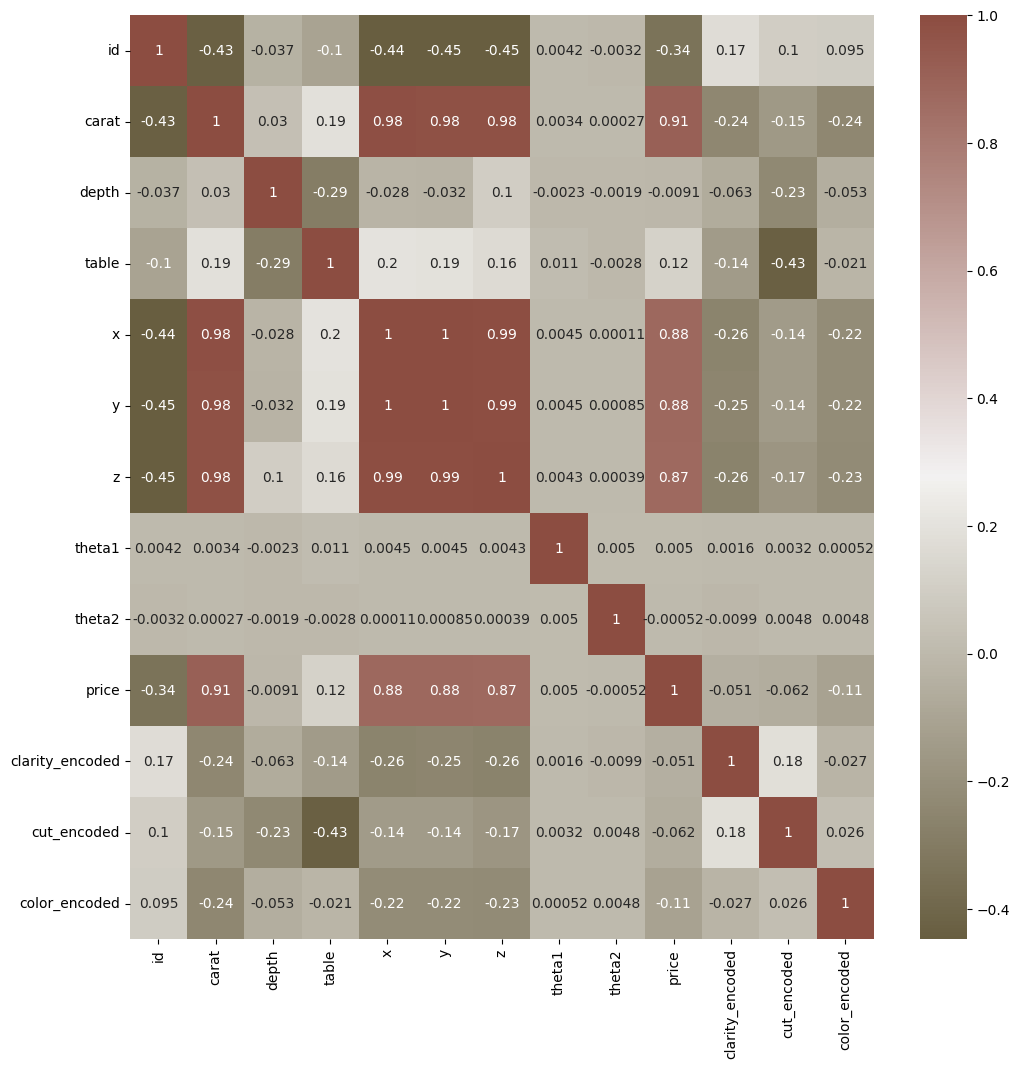

In [17]:
data_encoded = data_encoded[(data_encoded["depth"]<70)&(data_encoded["depth"]>55)]
data_encoded = data_encoded[(data_encoded["table"]<70)&(data_encoded["table"]>50)]
data_encoded = data_encoded[(data_encoded["x"]!=0)]
data_encoded = data_encoded[(data_encoded["y"]<30) & (data_encoded["y"]!=0)]
data_encoded = data_encoded[(data_encoded["z"]<30)&(data_encoded["z"]>2)]
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= data_encoded.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

Теперь видим, что и y имеет сильную корреляцию с таргетом. Также видим то, что theta1, theta2 не имеют корреляции с таргетом. Удаление выбросов не сильно повлияло на другие признаки. Попробуем закодировать категориальные признаки с помощью one-hot encoding.

<Axes: >

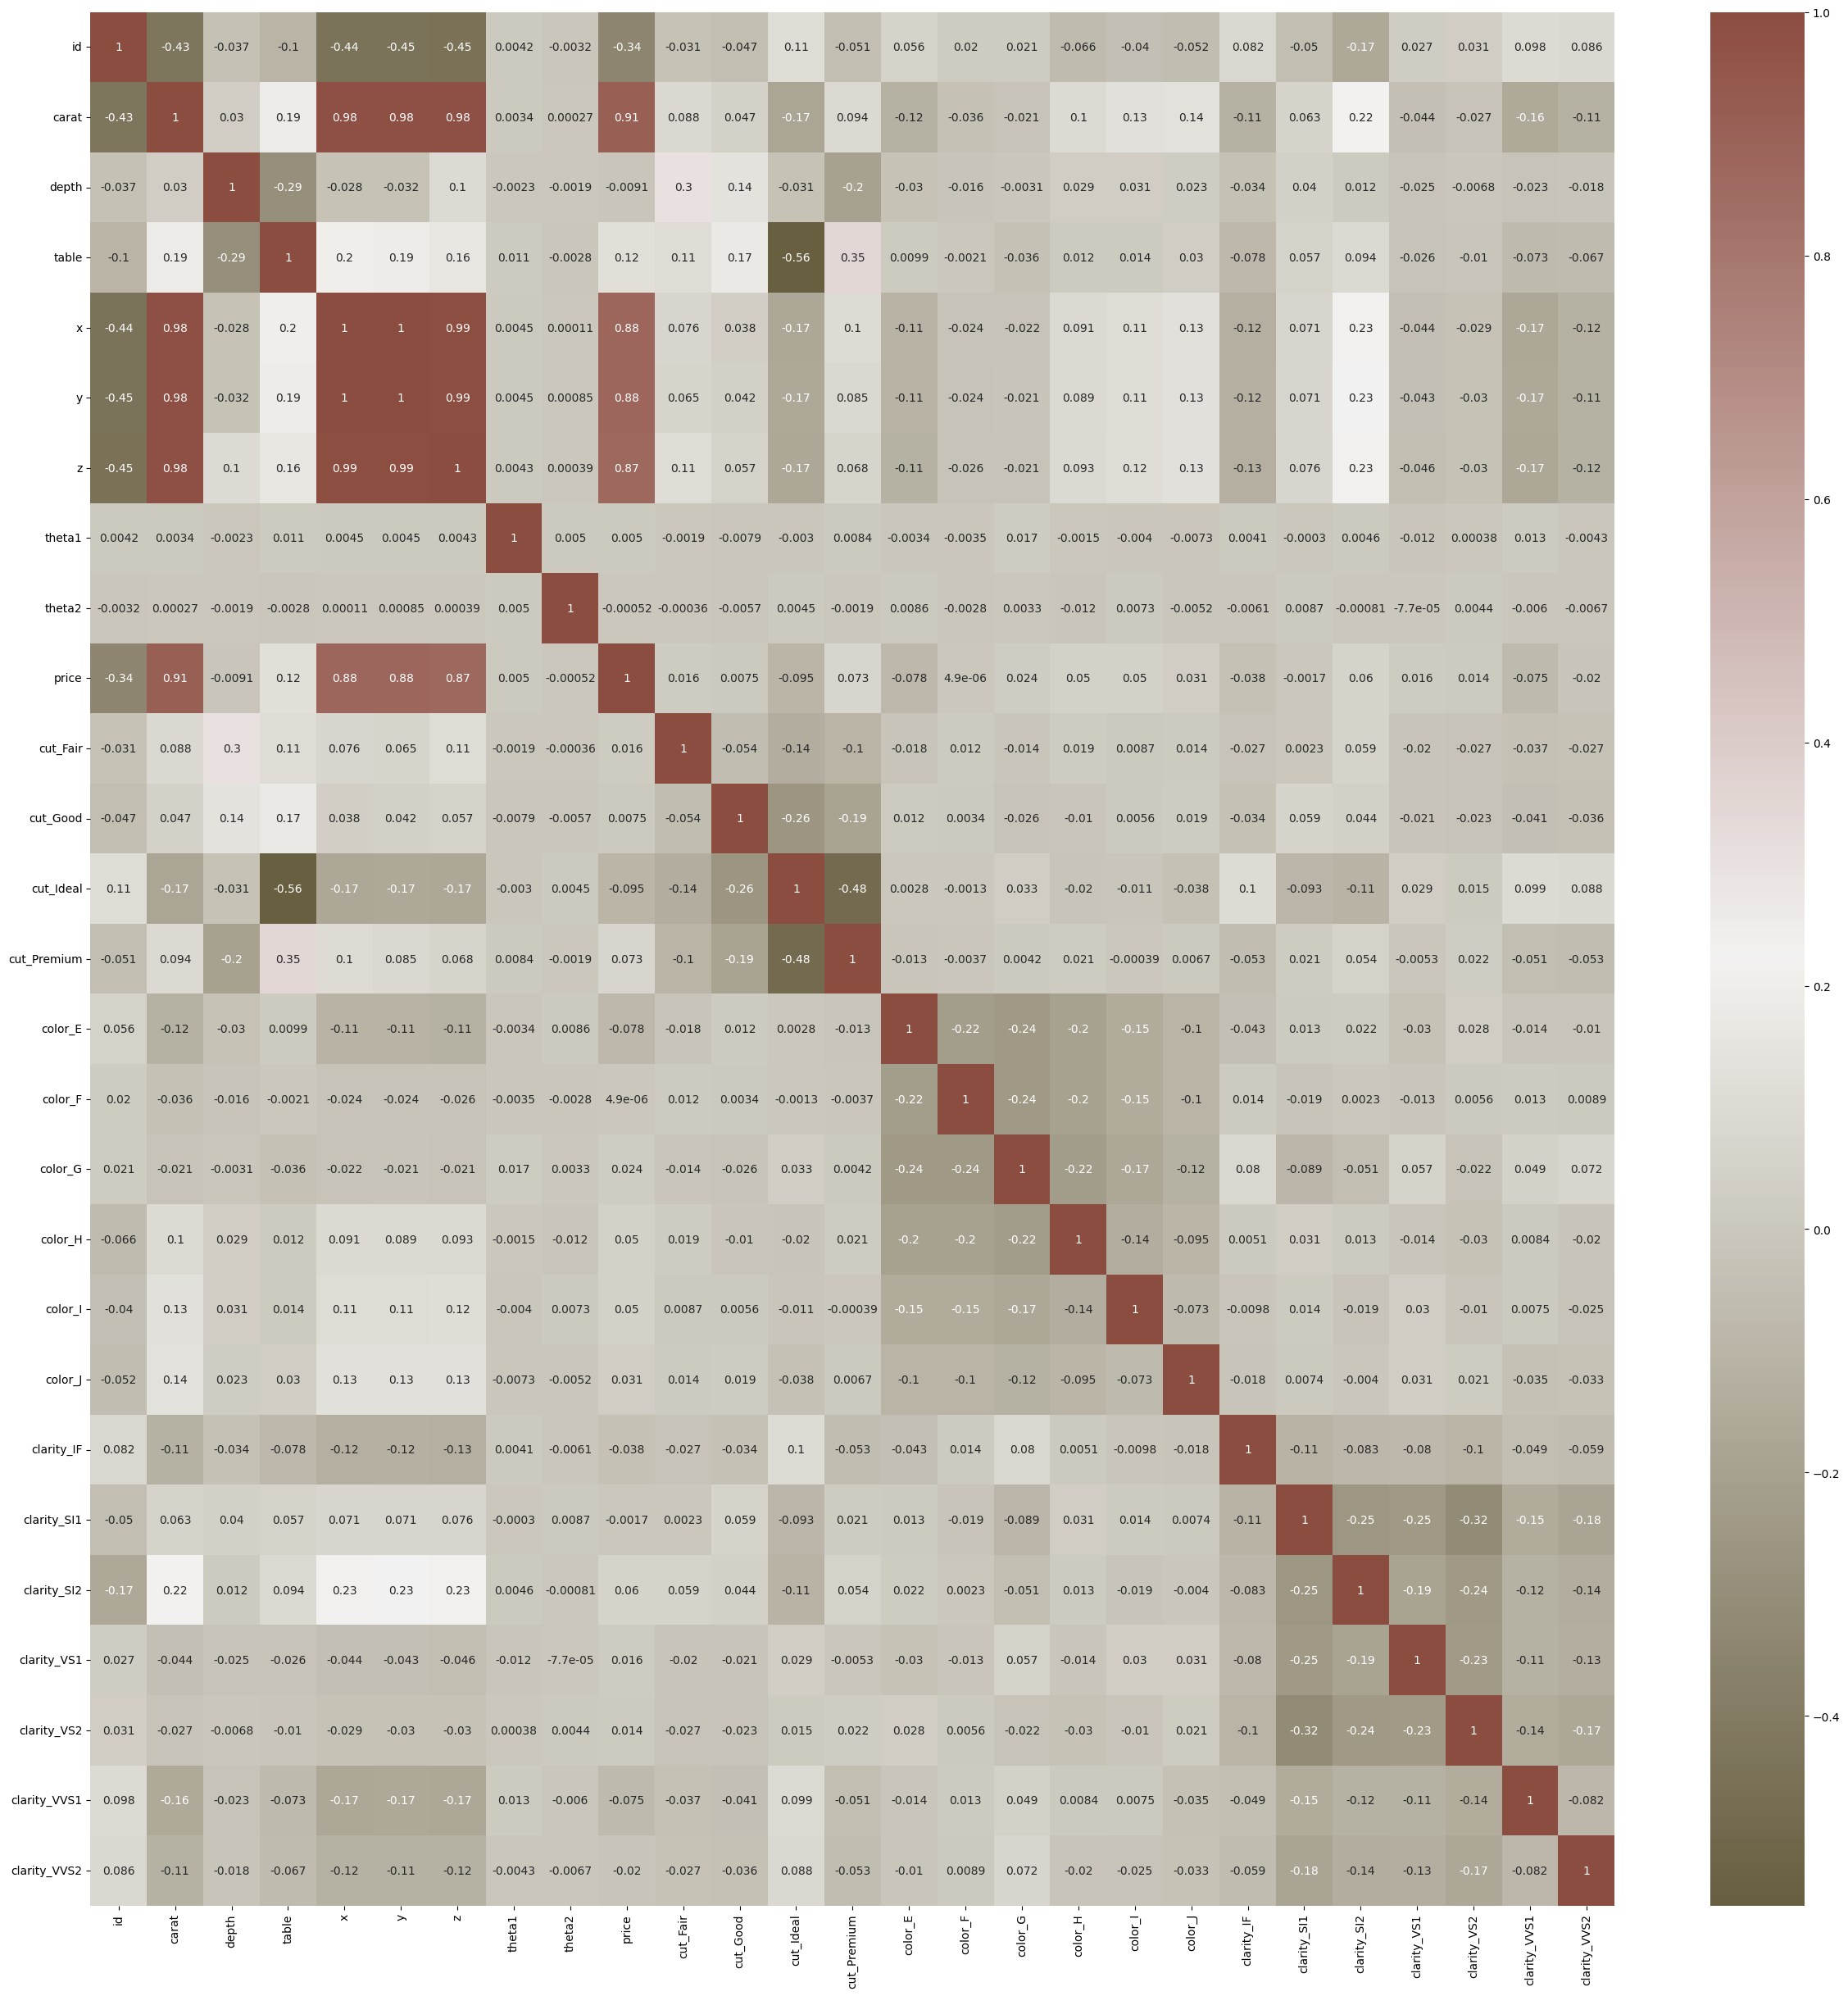

In [18]:
data_encoded = data.copy()
data_encoded = data_encoded[(data_encoded["depth"]<70)&(data_encoded["depth"]>55)]
data_encoded = data_encoded[(data_encoded["table"]<70)&(data_encoded["table"]>50)]
data_encoded = data_encoded[(data_encoded["x"]!=0)]
data_encoded = data_encoded[(data_encoded["y"]<30) & (data_encoded["y"]!=0)]
data_encoded = data_encoded[(data_encoded["z"]<30)&(data_encoded["z"]>2)]
X = pd.get_dummies(data_encoded, drop_first=True)
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= X.corr()
f, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

Ситуацию это не изменило. Цена все равно слабо зависит от cut, clarity, color. Теперь посмотрим природу зависимостей между значимыми признаками и ценой.

<Figure size 1000x600 with 0 Axes>

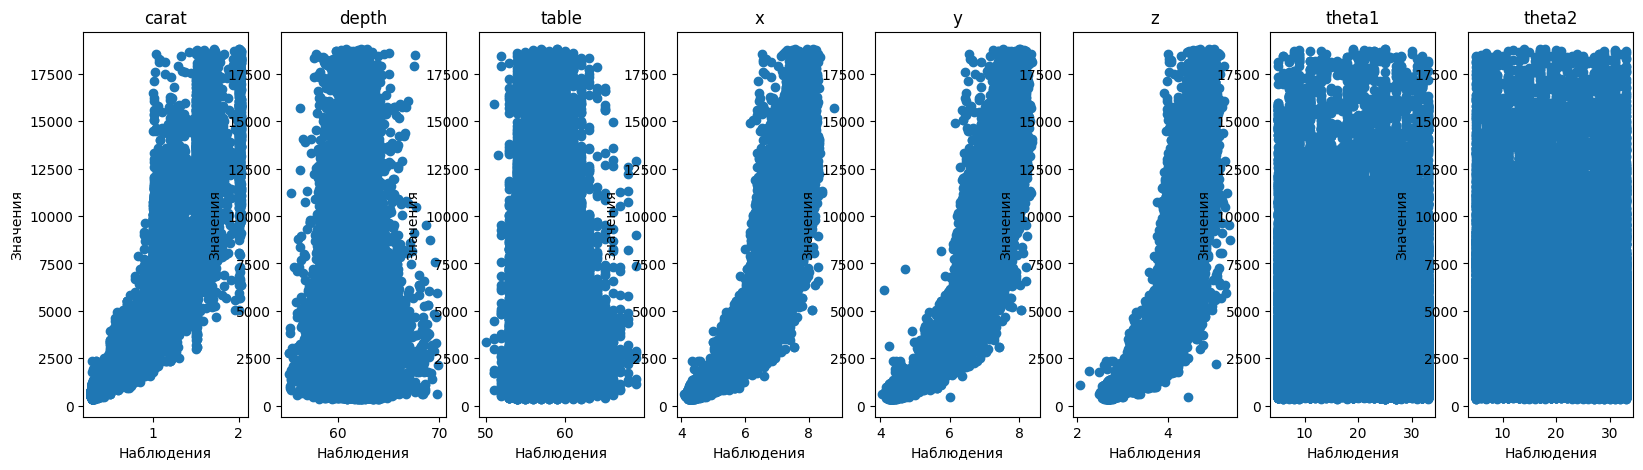

In [19]:
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(1, len(selected_columns), figsize=(20, 5))
for i, col in enumerate(selected_columns):
    axes[i].scatter(data_encoded[col], data_encoded['price'])
    axes[i].set_title(col) 
    axes[i].set_xlabel('Наблюдения')
    axes[i].set_ylabel('Значения') 
plt.show()

Зависимость видна только у x, y, z и carat причем нелинейная. Theta1, theta2 вообще не влияют на стоимость. Price равномерно распределен по значениям theta1, theta2. Делаем вывод, что эти столбцы нам не нужны. Другие столбцы оставим, хоть они и не вносят такой сильный вклад (но он всер авно больше, чем у theta1. theta2, плюс, рассуждая логически без математики, другие признаки все равно должны влиять на стоимость). Попробуем сделать зависимость линейной, изменяя признаки.

<Figure size 1000x600 with 0 Axes>

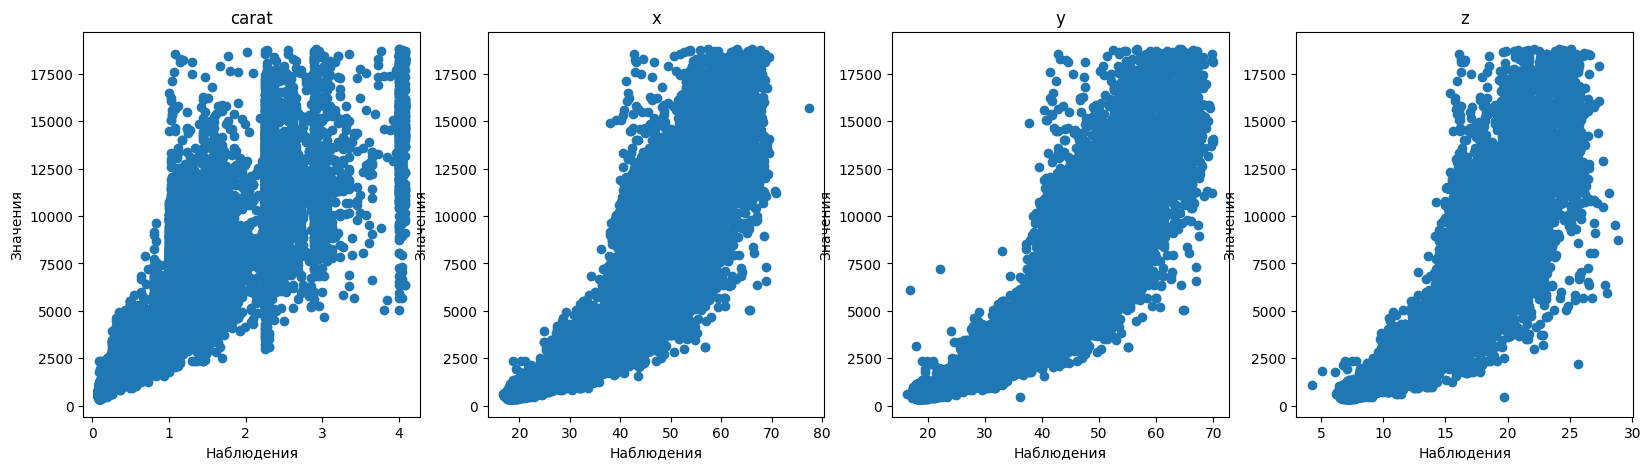

In [20]:
selected_columns = ['carat', 'x', 'y', 'z']
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(1, len(selected_columns), figsize=(20, 5))
for i, col in enumerate(selected_columns):
    axes[i].scatter(data_encoded[col] ** 2, data_encoded['price'])
    axes[i].set_title(col) 
    axes[i].set_xlabel('Наблюдения')
    axes[i].set_ylabel('Значения') 
plt.show()

<Figure size 1000x600 with 0 Axes>

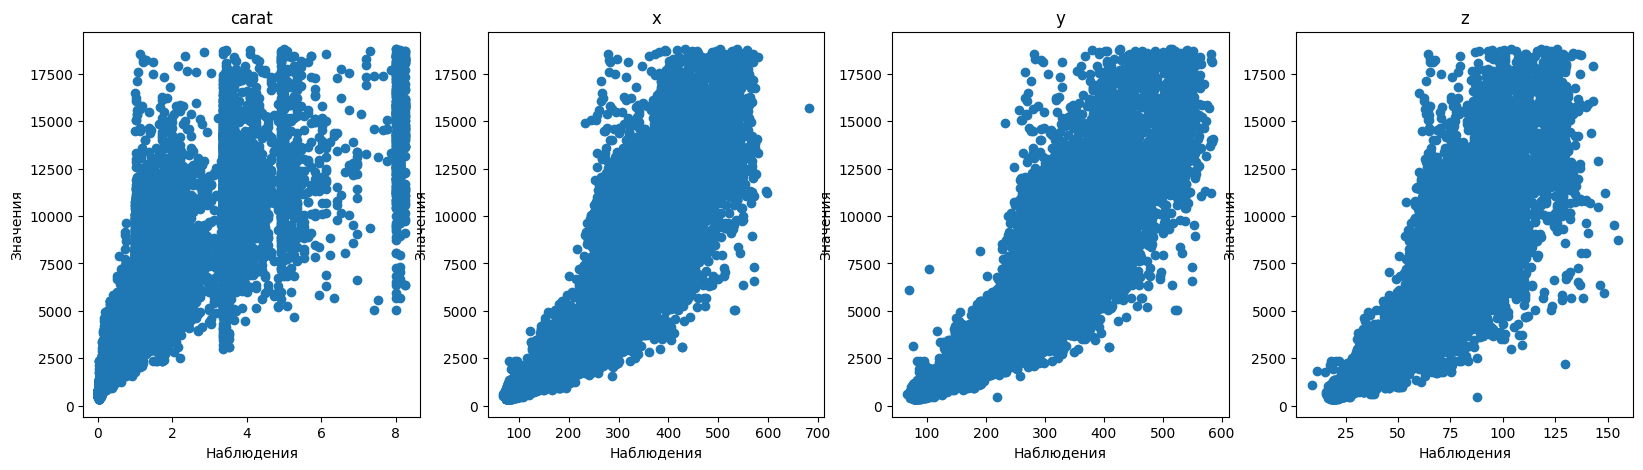

In [21]:
selected_columns = ['carat', 'x', 'y', 'z']
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(1, len(selected_columns), figsize=(20, 5))
for i, col in enumerate(selected_columns):
    axes[i].scatter(data_encoded[col] ** 3, data_encoded['price'])
    axes[i].set_title(col) 
    axes[i].set_xlabel('Наблюдения')
    axes[i].set_ylabel('Значения') 
plt.show()

Линейная зависимость для каратов выглядет лучше на второй степени, а для x, y, z на третьей. Отдельно исследуем id.

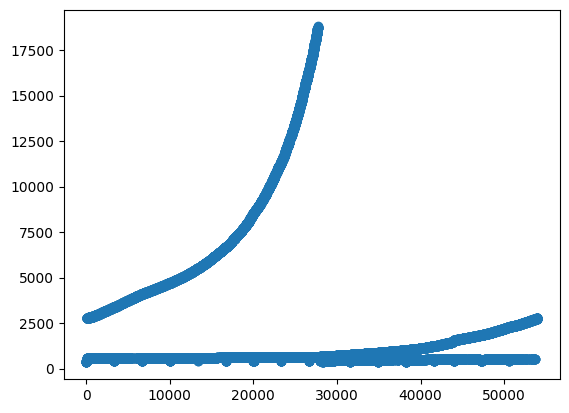

In [22]:
plt.scatter(data_encoded['id'], data_encoded['price'])

Видим что зависимость есть когда price становится достаточно большим, до 2500 зависимости практически нет. Видимо это связано с корреляцией с другим признаками, исследуем это.

<Figure size 1000x600 with 0 Axes>

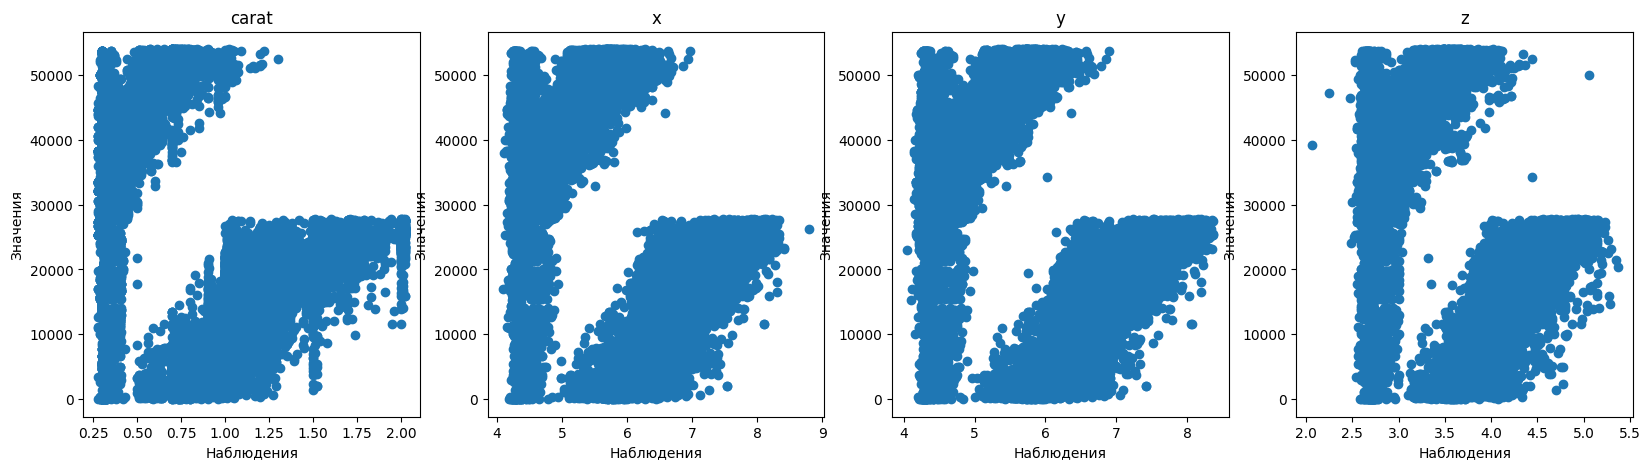

In [23]:
selected_columns = ['carat', 'x', 'y', 'z']
plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(1, len(selected_columns), figsize=(20, 5))
for i, col in enumerate(selected_columns):
    axes[i].scatter(data_encoded[col], data_encoded['id'])
    axes[i].set_title(col) 
    axes[i].set_xlabel('Наблюдения')
    axes[i].set_ylabel('Значения') 
plt.show()

Видим что при маленьких значениях x, y, z зависимости нет, но как только значения переходят определенный порог, сразу появляется зависимость. Причем при больших значениях x, y, z id не превосходит примерно 30000. Установить явно, почему есть такая зависимость с id не получилось (возможно, на самом деле это не просто номер алмаза, а какая-то дополнительная характеристика). Будем работать с этим.

### Preprocessing (подготовка данных)

Основных путей в препроцессинге было два. Первый из них - удаление строк с пропусками, удаление как можно большего числа выбросов, попытка побороть нелинейную зависимость цены от каратов и размеров путем изменения этих признаков.

In [16]:
# недействительный код
data = data.dropna()

for i in range (1, 4):
    cat_features_mask = (data.dtypes == "object").values
    z = np.abs(stats.zscore(data[data.columns[~cat_features_mask]]))
    data = data[(z<3).all(axis=1)]

data['carat'] = data['carat'] ** 2
data['x'] = data['x'] ** 3
data['y'] = data['y'] ** 3
data['z'] = data['z'] ** 3

# еще one-hot encoding и drop theta1 theta2

Сначала модель была обычной линейной регрессией, затем L1-регурялизация. Существенных успехов данных подход не принес, не было борьбы с корреляцией, а преобразование признаков не сильно помогало. В результате поисков был найден класс PolynomialFeatures. Этот класс генерирует новую матрицу признаков, состоящую из всех полиномиальных комбинаций признаков со степенью, меньшей или равной указанной степени. Этот подход сразу же значительно улучшил результаты и все дальнейшие попытки были направлены лишь на улучшение этого подхода. Такая генерация новых признаков намного лучше боролась с нелинейными зависимостями, а также боролась с мультиколлинеарностью, именно поэтому результаты так сильно отличались. Степень 3 была выбрана, так как было предположение о кубический зависимости таргета от некоторыъ признаков. 3 степень показывала лучшие результаты mae (если не учитывать степени больше, но на этих степенях было большое переобучение).

In [24]:
data = data[data.columns].apply(lambda x: x.fillna(x.value_counts().index[0]))

data = data[(data["x"]<30)]
data = data[(data["z"]<30)]
data = data[(data["y"]<30)]

data['volume'] = data['x'] * data['y'] * data['z'] + 3 * data['carat']
test['volume'] = test['x'] * test['y'] * test['z'] + 3 * test['carat']
data = data.drop(columns=['theta1', 'theta2'])
test = test.drop(columns=['theta1', 'theta2'])

Y = data[['price']]
data = data.drop(columns=['price'])
X_train, X_test, Y_train, Y_test = train_test_split(data, Y, test_size=0.2, random_state=my_seed)

X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
data = pd.get_dummies(data, drop_first=True)
test_ = pd.get_dummies(test, drop_first=True)

poly = PolynomialFeatures(degree=3)
X_arr = poly.fit_transform(X_train)
X = pd.DataFrame(X_arr)
Y_arr = poly.fit_transform(X_test)
y = pd.DataFrame(Y_arr)
Y_arr = poly.fit_transform(data)
data = pd.DataFrame(Y_arr)
Y_arr = poly.fit_transform(test_)
test_ = pd.DataFrame(Y_arr)

Предобработка данных помимо PolynomialFeatures включала в себя:
1) Заполнение пропусков - заполяем их модой для каждого столбца. Используем моду, во-первых, из-за категориальных признаков, так как является наиболее естественным для них, а во-вторых, потому что для других признаков медиана или среднее могут быть неустойчивыми, так как выбросы удаляем только по x, y, z.
2) Удаление выбросов - удаляем слишком большие значения x, y, z. Эти выбросы слишком сильно повлияют на итоговую модель, так как это ключевые признаки. Без удаления этих выбросов mean absolute error становилось хуже. Нули не удаляем, так как их удаление практически никак не сказывалось на mae, а также в тестовых данных также содержаться нулевые значения. Выбросов по каратам нет, их и не удаляем. Есть выбросы в table и depth, но их мы не удаляем, так как эти признаки мало влияют на модель, тем более, если мы удалим выбросы по этим признакам, можем потерять важную информацию по остальным, что потдверждалось значительных ухудшением mae.
3) Удаление theta1, theta2 - как было показано в первом разделе, эти признаки не несут никакой пользы, наоборот, даже могут помешать в связи с их случайной природой.
4) Добавление линейной комбинации самых значимых признаков - признак 'volume' (изначально там было перемножение x, y, z, но потом название было решено оставить) представляет собой своеобразную линейную комбинацию объема и каратов - самых значимых и коррелирующих признаков, добавление новых признаков, состоящих из комбинаций коррелирующих признаков, помогает с этим бороться. Караты добавляем с коэффициентом 3, изначально было предположение, что это признак нужно увеличить в значимости путем добавления коэффициента, это подтвердилось значением mae, еще одной причиной этому было то, что в тестовой выборке содержатся очень большие значения каратов (> 3), в train выборке такого нет.
5) One-hot encoding - наиболее простой способ борьбы с категориальными значениями. Иногда были попытки закодировать их числами в соответствии с классификацией, но mae это не улучшало, поэтому оставили этот способ.

На протяжении всей работы id не удалялось. Корреляцию отрицать сложно, тем более при попытках удалить id, mae значительно ухудшалось.

### Model & training (Выбор модели и её обучение)

Основных экспериментов в выборе модели было три, два из них были перед использованием PolynomialFeatures, финальный - после использования.

#### Эксперимент 1

In [21]:
model = LinearRegression()
model.fit(X, Y_train)

LinearRegression()

Первая, самая обычная модель. Показывала себя не очень хорошо, так как первоначально не было борьбы с мультиколлинеарностью, результаты были тем лучше, чем больше выбросов удалялось. На первых этапах даже запускали процесс удаления выбросов в цикле.

#### Эксперимент 2

In [22]:
model = Lasso()
model.fit(X, Y_train)

После долгих безуспешных попыток улучшить результат на обычной линейной модели в голову пришла идея использовать регурялизацию. Лучше всего себя показала L1-регурялизация. После ее использования результаты значительно улучшились. Скорее всего это связано с тем, что регуляризация помогает бороться с мультиколлинеарностью, и до того, как мы начали делать это в препроцессинге, регурялизация немного помогала в этом.

#### Эксперимент 3

In [25]:
model = LinearRegression()
model.fit(X, Y_train)

LinearRegression()

После использования PolynomialFeatures регуляризация перестала быть необходимостью, а дополнительная была лишней, и обычная линейная модель в связи с этим справлялась намного лучше. Поэтому было решено оставить ее.

### Evaluation (оценка качества модели)

In [26]:
from sklearn.metrics import mean_absolute_error
y_test_predicted = model.predict(y)
print(mean_absolute_error(y_test_predicted, Y_test))
y_test_predicted = model.predict(test_)
result = test[['id']]
result.insert(loc = 1,
          column = 'price',
          value = y_test_predicted)
result.to_csv("submission.csv", index = False)
print(result.head())

154.68700237686335
      id        price
0  14085  5789.467402
1  36447   865.312513
2  30782   896.878067
3  43299  1630.841529
4   3378  1041.398020


### Conclusion (Выводы)

Получили mae примерно 155 на примерно 8000 объектах, что является хорошим результатом для линейной регрессии. Можно прийти к выводу, что линейная регрессия - не лучшая для этой задачи: мультиколлинеарность, нелинейные зависимости между признаками и таргетами сильно мешают работе линейной регрессии. Колоссальную помощь в работе принесло использование PolynomialFeatures, которое как раз-таки борется с этими проблемами. Без использования этого подхода получение таких результатов - довольно сложная задача. Но даже у этого подхода были минусы - переобучение. Иногда mae получалось ниже 100, но на тестовых данных score был слишком большой. 

Не получилось выяснить истинную природу зависимости price от признаков, многие изначальные предположения не оправдались, такие признаки, как cut, clarity, color, которые, судя по реальной жизни, должны были иметь большое влияние на цену, на самом деле боказались малозначимыми. Также не получилось понять почему id имеет такое сильное влияние на таргет. Недостатком работы можно назвать то, что большинство решений принималось методом проб и ошибок, а затем уже приходило понимание, почему это работает/не работает.

Несмотря на это, получилось построить достаточно хорошую линейную модель с помощью встроенных инструментов препроцессинга.